In [4]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator, FormatStrFormatter, MultipleLocator, NullFormatter
import numpy as np
import pandas as pd
import os
from cmcrameri import cm
from scipy.interpolate import PchipInterpolator
from scipy.integrate import cumulative_trapezoid
import matplotlib.patheffects as pe
from copy import deepcopy

In [5]:
import utils.load_grid as lg
import utils.feathers
from proteus.config import read_config
from proteus.utils.constants import M_earth, M_jupiter, R_earth, R_jupiter, secs_per_year

In [6]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'
# %matplotlib widget

In [7]:
fwl_dir = os.environ.get("FWL_DATA")

In [8]:
def gauss1d(v,param):
    if v > param["mu"]:
        sig2 = param["sigp"]**2
    else:
        sig2 = param["sigm"]**2
    return np.exp(-0.5 * (v-param["mu"])**2/sig2) #/ np.sqrt(2*np.pi*sig2)

def gauss2d(x,y, x_param, y_param):
    return gauss1d(x, x_param) * gauss1d(y, y_param)

In [9]:
def _get_exo_data():
    popfile = os.path.join(fwl_dir, "planet_reference", "Exoplanets", "DACE_PlanetS.csv")
    return pd.read_csv(popfile,comment="#")

def _get_mr_data():
    z19 = os.path.join(fwl_dir, "mass_radius", "Mass-radius", "Zeng2019")

    # Set paths
    curves = {
        # "Earth-like":           os.path.join(z19, "massradiusEarthlikeRocky.txt"),
        r"Rocky + 0.3% H$_2$, 500 K":     os.path.join(z19, "Earthlike03h500K1mbar.txt"),
        r"MgSiO$_3$":           os.path.join(z19, "massradiusmgsio3.txt"),
        r"Rocky + 1% H$_2$, 500 K":     os.path.join(z19, "Earthlike1h500K1mbar.txt"),
    }

    # Replace paths with the data
    for k in curves.keys():
        data = np.loadtxt(curves[k]).T
        mask = np.argsort(data[0])
        curves[k] = [data[0][mask],data[1][mask]]

    return curves

# Get exoplanet values from database
exo = _get_exo_data()
print(list(exo.keys()))

exo_mas_val = exo["Planet Mass [Mjup]"]             * M_jupiter / M_earth
exo_mas_upp = exo["Planet Mass - Upper Unc [Mjup]"] * M_jupiter / M_earth
exo_mas_low = exo["Planet Mass - Lower Unc [Mjup]"] * M_jupiter / M_earth

exo_rad_val = exo["Planet Radius [Rjup]"]             * R_jupiter / R_earth
exo_rad_upp = exo["Planet Radius - Upper Unc [Rjup]"] * R_jupiter / R_earth
exo_rad_low = exo["Planet Radius - Lower Unc [Rjup]"] * R_jupiter / R_earth

exo_age_val = np.array(exo["Stellar Age [Gyr]"]   )  * 1e9    # yr
exo_rho_val = np.array(exo["Planet Density [g/cm**3] - Computation"]) # g cm-3

# Get Mass-Radius curves from files
mrdata = _get_mr_data()

['Unnamed: 0', 'Planet Name', 'Planet Letter', 'Host Name', 'TIC ID', 'Gaia DR3 ID', 'Discovery Year', 'Discovery Method', 'Discovery Facility', 'Discovery Locale', 'Number of stars', 'Number of planets', 'Reference', 'ADS link', 'Last Updated', 'Planet Mass [Mjup]', 'Planet Mass - Upper Unc [Mjup]', 'Planet Mass - Lower Unc [Mjup]', 'Relative Mass Error', 'Planet Msin(i) [Mjup]', 'Planet Msin(i) - Upper Unc [Mjup]', 'Planet Msin(i) - Lower Unc [Mjup]', 'Planet Radius [Rjup]', 'Planet Radius - Upper Unc [Rjup]', 'Planet Radius - Lower Unc [Rjup]', 'Relative Radius Error', 'Orbital Period [days]', 'Orbital Period - Upper Unc [days]', 'Orbital Period - Lower Unc [days]', 'Orbit Semi-Major axis [au]', 'Orbit Semi-Major axis - Upper Unc [au]', 'Orbit Semi-Major axis - Lower Unc [au]', 'Source of the Orbit Semi-Major axis', 'Eccentricity', 'Eccentricity - Upper Unc', 'Eccentricity - Lower Unc', 'Eccentricity Upper Limit Flag', 'Insolation Flux [Earth Flux]', 'Insolation Flux - Upper Unc [Ea

In [10]:
t0 = 1e2
m_max = 5
m_min = 0.1

In [11]:
pgrid_dir = "data/output/l98d_escape28/"
cases = lg.get_cases(pgrid_dir, only_completed=False)
ncases = len(cases)

cnums = [int(s.split("_")[-1]) for s in cases]
stts = lg.get_statuses(pgrid_dir)
helps, hvars = lg.load_helpfiles(cases)

confs = []
for f in cases:
    confs.append( read_config(f+"/init_coupler.toml") )

# transit, eclipse = lg.load_synthobs(cases)

age_start = float(helps[0]["age_star"].iloc[0])

print("Done")

Helpfiles: 100%|██████████| 432/432 [00:12<00:00, 34.45it/s]


Done


In [12]:
age_obs = {"mu":4.94e9-age_start, "sigm":1.44e9, "sigp":1.44e9, "min":800e6-age_start}

cmap_obs = {
    "Rajpaul+24":  plt.get_cmap("Greys"),
    "Demangeon+21":plt.get_cmap("Greens"),
    "Luque+22":    plt.get_cmap("Blues"),
    "Cloutier+19": plt.get_cmap("Oranges"),
}

# densities
rho_obs =  {
    "Rajpaul+24"  :{"cmap":cmap_obs["Rajpaul+24"  ], "mu":3.45,  "sigm":1.0,   "sigp":0.59},
    "Demangeon+21":{"cmap":cmap_obs["Demangeon+21"], "mu":2.95,  "sigm":0.51,  "sigp":0.79},
    "Luque+22"    :{"cmap":cmap_obs["Luque+22"    ], "mu":3.17,  "sigm":0.73,  "sigp":0.85},
    "Cloutier+19" :{"cmap":cmap_obs["Cloutier+19" ], "mu":3.30,  "sigm":0.90,  "sigp":1.30},
}

# masses
mas_obs =  {
    "Rajpaul+24"  :{"cmap":cmap_obs["Rajpaul+24"  ], "mu":2.14,  "sigm":0.29,   "sigp":0.25},
    "Demangeon+21":{"cmap":cmap_obs["Demangeon+21"], "mu":1.94,  "sigm":0.28,  "sigp":0.28},
    "Luque+22"    :{"cmap":cmap_obs["Luque+22"    ], "mu":2.31,  "sigm":0.45,  "sigp":0.46},
    "Cloutier+19" :{"cmap":cmap_obs["Cloutier+19" ], "mu":2.31,  "sigm":0.45,  "sigp":0.46},
}

# radii
rad_obs =  {
    "Rajpaul+24"  :{"cmap":cmap_obs["Rajpaul+24"  ], "mu":1.521, "sigm":0.098, "sigp":0.119},
    "Demangeon+21":{"cmap":cmap_obs["Demangeon+21"], "mu":1.521, "sigm":0.098, "sigp":0.119},
    "Luque+22"    :{"cmap":cmap_obs["Luque+22"    ], "mu":1.58,  "sigm":0.08,  "sigp":0.08},
    "Cloutier+19" :{"cmap":cmap_obs["Cloutier+19" ], "mu":1.57,  "sigm":0.14,  "sigp":0.14},
}

## Density over time

In [13]:
plt.close("all")

3.45 < age Gyr < 6.33
Cases which match density/age observations:
[8, 59, 60, 61, 62, 80, 112, 113, 114, 115, 116, 131, 132, 133, 134, 152, 164, 165, 166, 167, 168, 169, 170, 183, 184, 185, 186, 187, 188, 203, 205, 206, 218, 219, 220, 221, 222, 223, 224, 236, 237, 238, 239, 240, 241, 242, 256, 257, 258, 259, 260, 271, 272, 273, 274, 275, 276, 277, 278, 289, 290, 291, 292, 293, 294, 295, 296, 309, 310, 311, 312, 313, 314, 324, 325, 326, 327, 328, 329, 330, 331, 332, 342, 343, 344, 345, 346, 347, 348, 349, 350, 362, 363, 364, 365, 366, 367, 368, 378, 379, 380, 381, 382, 383, 384, 385, 386, 396, 397, 398, 399, 400, 401, 402, 403, 404, 415, 416, 417, 418, 419, 420, 421, 422]
2.4517716623882646


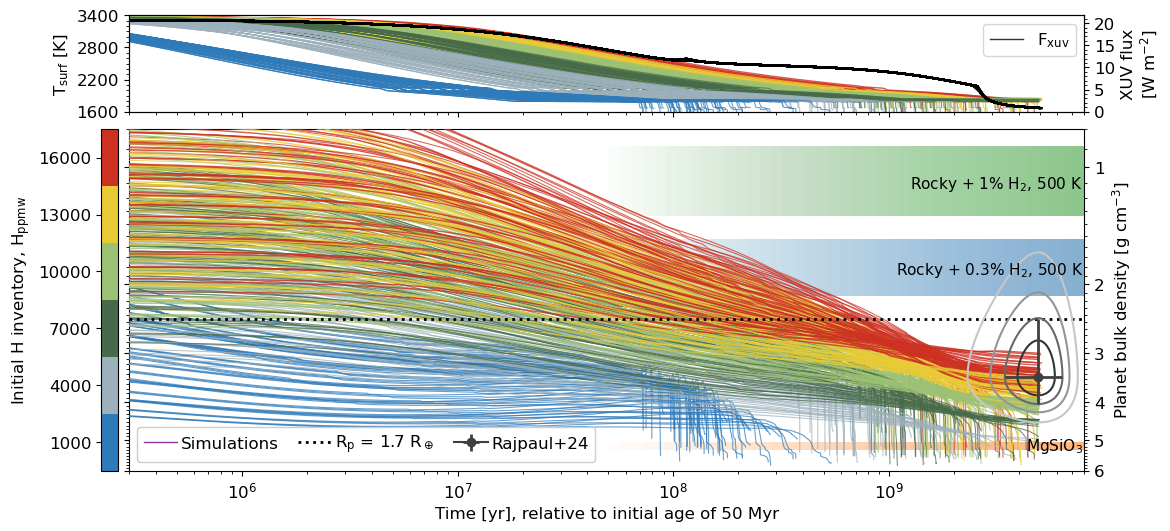

In [34]:
figscale=1.3
spr = 0.22
fig, axs = plt.subplots(2,1, figsize=(9*figscale,4*figscale),
                            sharex=True, height_ratios=(spr,1-spr) , layout='constrained')
axt = axs[0]
axr = axt.twinx()
ax  = axs[1]

tmin, tmax = 3e5, 8e9
xscale = "log"
yscale = "log"

plot_casenums = False

# zkey = "outgas.fO2_shift_IW"
# zlbl = r"Mantle oxygen fugacity, $\Delta$IW"
# cmap = cm.batlow_r

zkey = "delivery.elements.H_ppmw"
zlbl = r"Initial H inventory, H$_\text{ppmw}$"
cmap = plt.get_cmap("eastern_rosella_r")

# zkey = "delivery.elements.SH_ratio"
# zlbl = r"Initial S inventory, S/H"
# cmap = cm.lipari

# zkey = "struct.mass_tot"
# zlbl = r"Planet mass [M$_\oplus$]"
# cmap = plt.get_cmap("princess_parrot")

# zkey = "cnums"
# zlbl = "Case number"
# cmap = plt.get_cmap("viridis")

controls = {}
# controls = {"outgas.fO2_shift_IW":-5}
# controls = {"struct.mass_tot":2.14}
# controls = {"delivery.elements.H_ppmw":8e3}
# controls = {"delivery.elements.SH_ratio":10.0}

# Observations
def add_obs_contour(ax, x_obs, y_obs, x_samp, y_samp, label, colq=0.8):
    zo = 7
    s = 60
    al = 1.0
    levels = 5

    z_arr = np.zeros((len(x_samp), len(y_samp)))
    for i,x in enumerate(x_samp):
        for j,y in enumerate(y_samp):
            z_arr[j,i] = gauss2d(x, y, x_obs, y_obs)
    z_max = np.amax(z_arr)
    z_arr /= z_max
    vmin = -0.2

    cmap = deepcopy(y_obs["cmap"])
    ax.contour(x_samp,y_samp, z_arr, cmap=cmap, vmin=vmin, zorder=zo, alpha=al, levels=levels) # make contours

    c = cmap(colq)
    ax.errorbar(x_obs["mu"],y_obs["mu"],
                    xerr=[[x_obs["sigm"]],[x_obs["sigp"]]],
                    yerr=[[y_obs["sigm"]],[y_obs["sigp"]]],
                    zorder=zo, alpha=al, color=c, markersize=6, elinewidth=2, marker='o', label=label) # legend entry
    # ax.scatter(x_obs["mu"],y_obs["mu"]+y_obs["sigp"], zorder=zo, alpha=al, color=c, ec='none', s=s, marker='_')
    # ax.scatter(x_obs["mu"],y_obs["mu"]-y_obs["sigm"], zorder=zo, alpha=al, color=c, ec='none', s=s, marker='_')

x_inp = np.linspace(tmin, tmax, 200)
y_inp = np.linspace(0.1,  10,   200)
lit_ref = "Rajpaul+24"
for obs in (lit_ref,):
    add_obs_contour(ax, age_obs, rho_obs[obs], x_inp, y_inp, obs)


cmap = deepcopy(cmap)
zvals = []
for i in range(ncases):
    if zkey == "cnums":
        zvals.append(cnums[i])
    elif "." in zkey:
        zvals.append(lg.descend_get(confs[i], zkey))

zvals = np.unique(zvals)
norm = mpl.colors.Normalize(vmin=zvals[0], vmax=zvals[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ls = 'solid'
lw = 1.0
al = 0.8

age_min = age_obs["mu"]-age_obs["sigm"]
age_max = age_obs["mu"]+age_obs["sigp"]
print("%.2f < age Gyr < %.2f"%(age_min/1e9, age_max/1e9))

masses_all = []
radii_all   = []
matches_rho = []
for i in range(ncases):

    # get config
    skip = False
    if controls:
        for k in controls:
            if not np.isclose(controls[k], lg.descend_get(confs[i],k)):
                skip = True
    if skip:
        continue
    if 20 < stts[cnums[i]] < 29: # error
        continue

    # get data
    hf_crop = helps[i][3:]
    time = np.array(hf_crop["Time"])

    sim_rad = np.array(hf_crop["R_obs"])
    sim_mas = np.array(hf_crop["M_planet"])
    sim_rho = 3*sim_mas/(4*np.pi*sim_rad**3)  * 0.001
    sim_rad /= R_earth
    sim_mas /= M_earth

    sim_Fxuv = np.array(hf_crop["F_xuv"])  # W/m^2
    sim_Rxuv = np.array(hf_crop["R_xuv"])
    sim_Pxuv = sim_Rxuv**2 * np.pi * 4 * sim_Fxuv  # Watts
    sim_Exuv = cumulative_trapezoid(sim_Pxuv, time, initial=0) # J

    sim_mmw = np.array(hf_crop["atm_kg_per_mol"]) * 1e3 # g/mol

    sim_Tsurf = np.array(hf_crop["T_surf"])

    sim_esc_rate = np.array(hf_crop["esc_rate_total"]) # kg/s
    sim_esc_rate *= secs_per_year * 1e6 # kg/yr
    sim_esc_rate /= 1e20

    if zkey == "cnums":
        z = cnums[i]
    elif "." in zkey:
        z = lg.descend_get(confs[i], zkey)


    # store mass statistics
    masses_all.extend(sim_mas)
    radii_all.extend(sim_rad)

    # does this case pass through observed region?
    rho_param = rho_obs[lit_ref]
    rho_min = rho_param["mu"]-rho_param["sigm"]*1.5
    rho_max = rho_param["mu"]+rho_param["sigp"]*1.5
    mask = np.argwhere( (sim_rho >= rho_min) & ( sim_rho <= rho_max))
    ages = time[mask] + age_start
    if np.any( (ages >= age_min) & (ages <= age_max)):
        # roughly matches
        matches_rho.append(cnums[i])
        _lw = lw
        _al = al
    else:
        # does not match
        _lw = lw * 0.8
        _al = al * 0.9

    # plot density
    color = sm.to_rgba(z)
    ax.plot(time, sim_rho, color=color, lw=_lw, alpha=_al, zorder=6,  ls='solid')

    # plot surface temperature
    axt.plot(time, sim_Tsurf, color=color, lw=_lw, alpha=_al)

    # plot Fxuv
    axr.plot(time, sim_Fxuv, color='black', alpha=0.7)

    # annotate
    if plot_casenums:
        x = time[-1]
        y = sim_rho[np.argmin(np.abs(time - x))]
        if x > tmin:
            ax.text(x, y, str(cnums[i]), fontsize=8, zorder=9, color='crimson', horizontalalignment='center', verticalalignment='center')

# legend entry
axr.plot([1,2], [1,2], c='black', lw=lw, alpha=al, zorder=0, label=r"F$_\text{xuv}$", ls='solid')
ax.plot( [1,2], [1,2], c='purple', lw=lw, alpha=al, zorder=0, label= "Simulations", ls='solid')

print("Cases which match density/age observations:")
print(matches_rho)

# M-R curves
mass_min = np.amin(masses_all)
mass_max = np.amax(masses_all)
al = 0.6
for k in mrdata.keys():
    m_curve = mrdata[k][0] * M_earth
    r_curve = mrdata[k][1] * R_earth
    rho_curve = 3*m_curve/(4*np.pi*r_curve**3)  * 0.001

    rho_interp = PchipInterpolator(m_curve, rho_curve)
    rho_min = rho_interp(mass_min * M_earth)
    rho_max = rho_interp(mass_max * M_earth)
    rho_med = 0.5 * (rho_min + rho_max)

    nsamp = 42
    mr_r = tmax
    mr_l = np.logspace(np.log10(5e7), np.log10(mr_r), nsamp)
    c = None
    for i in range(0,nsamp):
        if i == 0:
            c = ax.fill_between([1,2],1,2).get_fc() # generate colour
            ax.text(mr_r*0.99, rho_med, k, horizontalalignment='right', verticalalignment='center', fontsize=11, zorder=20)
        else:
            lbl = ""
        ax.fill_between([mr_l[i], mr_r], rho_min,  rho_max, color=c, zorder=4, alpha=0.7/nsamp, ec='none')

# Exoplanets
# ax.scatter(exo_age_val-age_start, exo_rho_val,
#             color='gold', label="Exoplanets", s=6, zorder=5, edgecolors='none')

# Radius valley
m_ref = np.median(masses_all) * M_earth
R_ref = 1.7
rho_ref = 3 * m_ref / (4 * np.pi * (R_ref*R_earth)**3) / 1e3 # g/cm^3
print(rho_ref)
ax.axhline(y=rho_ref, lw=lw*2, ls='dotted', zorder=6,
                label=r"R$_\text{p}$ = %.1f R$_\oplus$"%R_ref, color='k')

ax.set_xlim(left=tmin, right=tmax)
ax.set_xlabel("Time [yr], relative to initial age of %g Myr"%(age_start/1e6))
ax.set_xscale(xscale)

ax.yaxis.tick_right()
ax.yaxis.set_ticks_position('both')
ax.yaxis.set_label_position("right")
ax.set_ylabel(r"Planet bulk density [g cm$^{-3}$]")
ax.set_yscale(yscale)
ax.set_ylim(bottom=6, top=0.8)
ax.yaxis.set_major_formatter(FormatStrFormatter("%g"))
ax.yaxis.set_major_locator(MultipleLocator(1.0))
ax.yaxis.set_minor_formatter(NullFormatter())
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

# axt.set_ylabel("Escape rate\n" + r"[10$^{20}$ kg/yr]")
# axt.set_yticks([0, 1, 2, 3])
# axt.set_ylim(bottom=0)

axt.set_ylabel(r"T$_\text{surf}$ [K]")
axt.set_yticks([1600, 2200, 2800, 3400])
axt.set_ylim(1600, 3400)
axt.yaxis.set_minor_locator(MultipleLocator(100))

axr.set_ylabel("XUV flux\n" +r"[W m$^{-2}$]")
axr.set_yticks([0, 5, 10, 15, 20])
axr.set_ylim(bottom=0)
axr.yaxis.set_minor_locator(MultipleLocator(1))
axr.legend()

cbpad = -0.06
if len(zvals) > 7:
    fig.colorbar(sm, ax=[ax], pad=cbpad, label=zlbl, location='left')
else:
    fig.colorbar(sm, ax=[ax], pad=cbpad, label=zlbl, values=zvals, ticks=zvals, location='left')

leg = ax.legend(loc='lower left', ncols=4, handletextpad=0.2, framealpha=1, columnspacing=1.2)
leg.set_zorder(99)
fig.savefig("output/density.pdf",bbox_inches='tight')
plt.show()

## Parameter projection

In [15]:
alphabet = "abcdefghijklmnop"

Plotting delivery.elements.H_ppmw
Plotting outgas.fO2_shift_IW
Plotting delivery.elements.SH_ratio
Plotting struct.mass_tot
Plotting atm_kg_per_mol
Plotting Phi_global
Plotting H2S_vmr


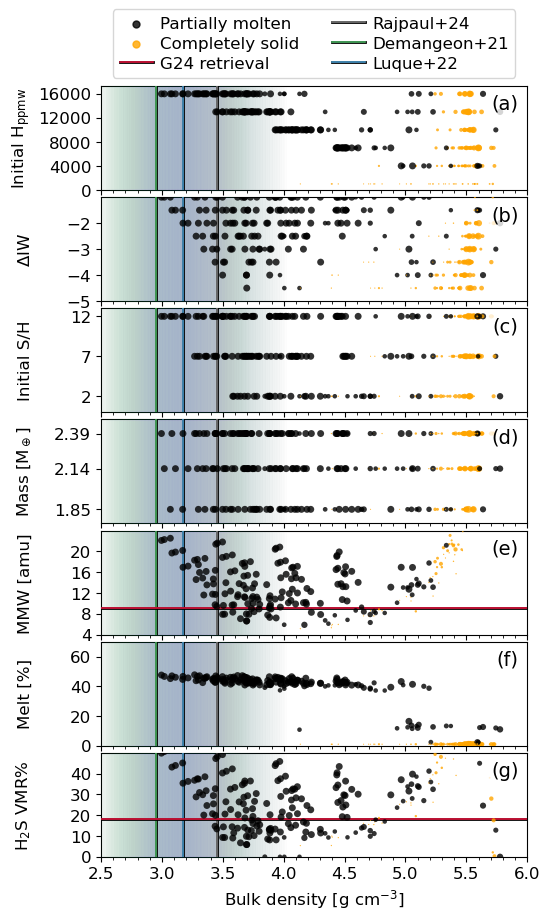

In [35]:
keys = []
lbls = []
scls = []
lims = []
tcks = []
yobs = []

keys.append( "delivery.elements.H_ppmw" )
lbls.append( r"Initial H$_\text{ppmw}$" )
scls.append( 1.0 )
lims.append( (0, None) )
tcks.append( [0, 4e3, 8e3, 12e3, 16e3] )
yobs.append( None )

keys.append( "outgas.fO2_shift_IW" )
lbls.append( r"$\Delta$IW" )
scls.append( 1.0 )
lims.append( (-5, -1) )
tcks.append( [-5, -4, -3, -2] )
yobs.append( None )

keys.append( "delivery.elements.SH_ratio" )
lbls.append( "Initial S/H" )
scls.append( 1.0 )
lims.append( (0, 13) )
tcks.append( [2, 7, 12] )
yobs.append( None )

keys.append( "struct.mass_tot" )
lbls.append( r"Mass [M$_\oplus$]" )
scls.append( 1.0 )
lims.append( (1.75, 2.49) )
tcks.append( [1.85, 2.14, 2.39] )
yobs.append( None )

keys.append( "atm_kg_per_mol" )
lbls.append( r"MMW [amu]" )
scls.append( 1000.0 )
lims.append( (4, 24) )
tcks.append( [4, 8, 12, 16, 20  ] )
yobs.append( 9.18 )

keys.append( "Phi_global" )
lbls.append( r"Melt [%]" )
scls.append( 100.0 )
lims.append( (0, 70) )
tcks.append( [0, 20, 40, 60] )
yobs.append( None )

keys.append( "H2S_vmr" )
lbls.append( r"H$_2$S VMR%" )
scls.append( 100.0 )
lims.append( (0, 50) )
tcks.append( [0, 10, 20, 30, 40] )
yobs.append( 10**-0.74*100 )

# keys.append( "P_surf" )
# lbls.append( r"P$_\text{surf}$" )
# scls.append( 1.0 )
# lims.append( (0, None) )
# tcks.append( [] )

controls = {}
# controls = {"struct.mass_tot":1.94}

show_casenums = False
show_ranking  = False
incl_obs = ["Rajpaul+24", "Demangeon+21", "Luque+22"]
marker = 'o'
ms = 25
lw = 1.2
al = 0.8
xmin, xmax = 2.5, 6.0

ttgt = age_obs["mu"]
rho_ref = rho_obs[lit_ref]["mu"]

def map_color(time, phi):

    # solidified
    if phi <= 0.015:
        return 'orange'

    # molten in recent times
    if (time >= age_obs["mu"]-age_obs["sigm"]*2):
        return 'black'

    # else
    return None

# init plot
figscale = 1.1
nax = len(keys)
fig,axs = plt.subplots(nax, 1, figsize=(5*figscale,1.3*figscale*nax))

# legend entries for status
dict_st = {
    "Partially molten" : (1e99,1.0),
    "Completely solid" : (1e99,0.0),
}
for st,va in dict_st.items():
    c = map_color(*va)
    if c:
        axs[0].scatter(-1,-1e4,c=c,label=st, marker=marker, s=ms, alpha=al)

# y-axis free chemistry retrieval
fc_col = 'crimson'
fc_lw = lw
fc_al = 1.0
axs[0].axhline(-1e4, color=fc_col, lw=fc_lw, ls='solid', zorder=30,
                    alpha=fc_al, label="G24 retrieval",
                    path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

# plot results

for j in range(nax):
    key = keys[j]
    scl = scls[j]
    axs[j].set_ylabel(lbls[j])
    xarr = []
    yarr = []
    zarr = [] # status value
    darr = []

    print("Plotting "+key)

    for i in range(ncases):

        # get config
        skip = False
        if controls:
            for k in controls:
                if not np.isclose(controls[k], lg.descend_get(confs[i],k)):
                    skip = True
        if skip:
            continue

        # find closest index in helpfile
        help = helps[i].iloc[3:]
        t_arr = np.array(help["Time"]) + age_start
        idx_close = np.argmin(np.abs(t_arr - ttgt))
        t = t_arr[idx_close]

        if "." in key:
            y = lg.descend_get(confs[i], key)
        else:
            y = help[key].iloc[idx_close]
        y *= scl
        x = help["rho_obs"].iloc[idx_close] / 1e3

        if t > age_obs["mu"]-age_obs["sigm"]*2:
            d = abs(x - rho_ref)/rho_ref * 100.0 # pct difference
        else:
            d = 1e99
        darr.append([cnums[i],x,d])

        phi = help["Phi_global"].iloc[idx_close]

        z = map_color(t,phi)
        if z is None:
            continue

        mf = 1-np.abs(t - ttgt)/ttgt
        # print("%.2e"%t_arr[idx_close], mf)

        zarr.append(z)
        xarr.append(x)
        yarr.append(y)


        axs[j].scatter(x,y, c=z, marker=marker, s=mf*ms, edgecolor='none', zorder=20, alpha=al)

        if show_casenums:
            if (lims[j][1] is None or y <= lims[j][1]) and (lims[j][0] is None or y >= lims[j][0]):
                axs[j].text(x,y,str(cnums[i]), fontsize=7, color='deepskyblue', zorder=40, horizontalalignment='center', verticalalignment='center')

    yl, yr = axs[j].get_ylim()
    if lims[j][0] is not None:
        yl = lims[j][0]
    if lims[j][1] is not None:
        yr = lims[j][1]

    for obs in incl_obs:
        x_med = rho_obs[obs]["mu"]
        c = rho_obs[obs]["cmap"](0.6)

        if j == 0:
            lbl = obs
        else:
            lbl = ""
        axs[j].axvline(x=x_med, color=c, label=lbl, ls='solid', lw=lw,
                            zorder=6, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

        nsamp = 30
        for i in range(nsamp):
            x_min = x_med - rho_obs[obs]["sigm"] * i/nsamp
            x_max = x_med + rho_obs[obs]["sigp"] * i/nsamp
            axs[j].fill_betweenx([yl, yr], x_min, x_max, zorder=4, alpha=0.2/nsamp, color=c)

    axs[j].set_ylim(yl, yr)
    axs[j].set_xlim(xmin, xmax)
    if len(tcks[j]) > 0:
        axs[j].set_yticks(tcks[j])

    axs[j].text(0.98, 0.92, f'({alphabet[j]})', fontsize=14, zorder=99,
                    horizontalalignment='right', verticalalignment='top', transform=axs[j].transAxes,
                    bbox=dict(facecolor='w', alpha=0.8, ec='none'))

    if yobs[j] is not None:
        axs[j].axhline(yobs[j], color=fc_col, lw=fc_lw, ls='solid', zorder=9,
                        alpha=fc_al, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

    if j != nax-1:
        axs[j].set_xticklabels([])

axs[0].legend(loc='lower center',bbox_to_anchor=(0.5,1), ncols=2, handletextpad=0.4, labelspacing=0.3)
axs[-1].set_xlabel(r"Bulk density [g cm$^{-3}$]")
for ax in axs:
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))

fig.align_ylabels(axs[:])
fig.subplots_adjust(hspace=0.07)

plt.show()
fig.savefig("output/density_blame.pdf", bbox_inches='tight')

In [17]:
darr = np.array(darr)
ind = np.argsort( darr[:,2] )
darr = darr[ind]
for i in range(len(darr)):
    cn  = darr[i,0]
    rho = darr[i,1]
    dst = darr[i,2]
    print("Case %3d: rho = %.2f, d = %.1f%%"%(cn, rho, dst))

Case 167: rho = 3.45, d = 0.0%
Case 403: rho = 3.46, d = 0.1%
Case 404: rho = 3.44, d = 0.2%
Case 221: rho = 3.44, d = 0.3%
Case 327: rho = 3.44, d = 0.3%
Case 116: rho = 3.44, d = 0.4%
Case 274: rho = 3.42, d = 0.8%
Case 222: rho = 3.42, d = 0.8%
Case 169: rho = 3.42, d = 1.0%
Case 350: rho = 3.50, d = 1.4%
Case 402: rho = 3.50, d = 1.4%
Case  62: rho = 3.50, d = 1.4%
Case 115: rho = 3.51, d = 1.6%
Case 113: rho = 3.52, d = 1.9%
Case 220: rho = 3.52, d = 2.0%
Case 273: rho = 3.53, d = 2.2%
Case 349: rho = 3.53, d = 2.3%
Case 275: rho = 3.37, d = 2.3%
Case 328: rho = 3.36, d = 2.5%
Case 381: rho = 3.35, d = 2.8%
Case 170: rho = 3.34, d = 3.1%
Case 296: rho = 3.56, d = 3.3%
Case 168: rho = 3.56, d = 3.3%
Case 223: rho = 3.33, d = 3.3%
Case 166: rho = 3.58, d = 3.7%
Case 348: rho = 3.58, d = 3.7%
Case 272: rho = 3.58, d = 3.8%
Case 326: rho = 3.59, d = 4.1%
Case 329: rho = 3.31, d = 4.1%
Case 295: rho = 3.60, d = 4.3%
Case 276: rho = 3.30, d = 4.4%
Case 382: rho = 3.29, d = 4.6%
Case 224

In [18]:
stts[32]

10

## Animation

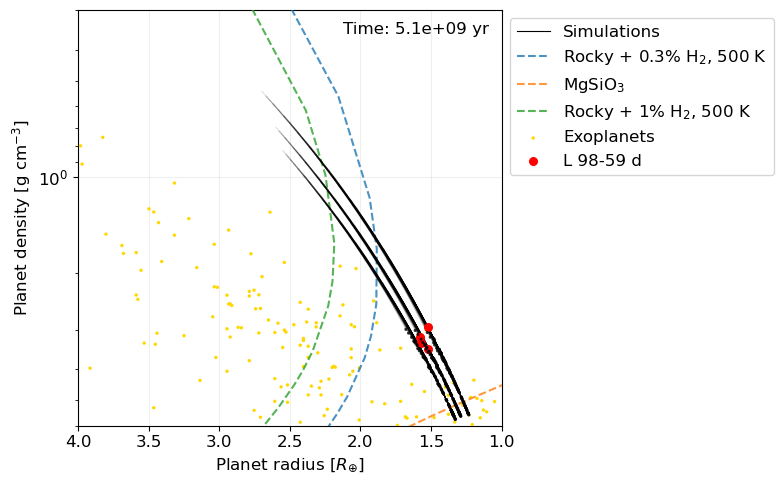

In [19]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

ymin, ymax = 0.3, 6
xmin, xmax = 1.0, 4
tmin, tmax = 1e4, 1e5

ax.set_xlabel(r"Planet radius [$R_{\oplus}$]")
ax.set_xlim(xmax, xmin)
ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax.xaxis.set_minor_formatter(FormatStrFormatter("%.1f"))

ax.set_ylabel(r"Planet density [g cm$^{-3}$]")
ax.set_yscale("log")
ax.set_ylim(ymax, ymin)

lines = []

# Create lines for simulations
for i in range(ncases):
    x,y = [], []
    if i == 0:
        lbl = "Simulations"
    else:
        lbl = ""
    l = ax.plot(x, y, color='k', lw=0.8, zorder=13, label=lbl)[0]
    lines.append(l)

# Create endpoints
for i in range(ncases):
    x,y = [],[]
    l = ax.scatter(x, y, color='k', s=5, zorder=13, edgecolors='none')
    lines.append(l)

    # get time
    tmax = max(tmax, np.amax(helps[i]["Time"]))

# Time
l = ax.text(0.97, 0.97, "Time: [unset]", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
lines.append(l)
itext = len(lines)-1

# M-R curves
for k in mrdata.keys():
    m = mrdata[k][0] * M_earth
    r = mrdata[k][1] * R_earth
    rho = 3*m/(4*np.pi*r**3)  * 0.001
    l = ax.plot(r/R_earth,rho, label=k, linestyle='dashed', alpha=0.8, zorder=10)[0]
    lines.append(l)

# Exoplanets
lbl = "Exoplanets"
ms=6
l = ax.scatter(exo_rad_val, exo_rho_val, color='gold', label=lbl, s=ms, zorder=9, edgecolors='none')
lines.append(l)

# Radius valley
# l = ax.fill_between([xmin,xmax], 1.5, 2.0, zorder=8,alpha=0.2, color='gold', ec='none', label="Radius valley")
# lines.append(l)

# Observations
lines.append(ax.scatter(1.52,2.95, s=30, zorder=12, color='red', label="L 98-59 d"))
lines.append(ax.scatter(1.52,3.45, s=30, zorder=12, color='red'))
lines.append(ax.scatter(1.58,3.17, s=30, zorder=12, color='red'))
lines.append(ax.scatter(1.57,3.30, s=30, zorder=12, color='red'))

# Decorate
ax.grid(alpha=0.2, zorder=-2)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
fig.tight_layout()

def update(t):

    # for each case
    for i in range(ncases):
        hf_all = helps[i]

        # get index of closest time
        idx_close = np.argmin(np.abs(t - hf_all["Time"]))
        hf_crop = hf_all.iloc[range(idx_close)]
        if len(hf_crop["Time"]) < 3:
            continue

        col = 'k'

        # get data
        time = np.array(hf_crop["Time"])
        sim_tmp = np.array(hf_crop["T_surf"])
        sim_rad = np.array(hf_crop["R_obs"])
        sim_mas = np.array(hf_crop["M_planet"])
        sim_rho = 3*sim_mas/(4*np.pi*sim_rad**3)  * 0.001

        sim_rad /= R_earth
        sim_mas /= M_earth

        y = sim_rho
        x = sim_rad

        iline = i
        iscat = i + ncases

        lines[iline].set_data(x, y)
        lines[iscat].set_offsets([x[-1],y[-1]])

        # is this the last sample?
        if idx_close >= len(hf_all)-1:
            # yes
            lines[iscat].set_alpha(0.8)
            lines[iline].set_alpha(0.1)
            lines[iline].set_zorder(11)
        else:
            # no
            lines[iscat].set_alpha(0.0)
            lines[iline].set_alpha(0.8)

    lines[itext].set_text("Time: %.1e yr"%t)

    return lines

duration = 8.0
nframes  = 5

# make animation
time_arr = np.logspace(np.log10(tmin), np.log10(tmax), nframes)
# time_arr = np.linspace(tmin, tmax, nframes)
ani = FuncAnimation(fig, update, frames=time_arr, blit=True, interval=duration/len(time_arr)*1e3)

# save and show
ani.save(filename="output/animate.gif", writer="ffmpeg")
HTML(ani.to_jshtml())